In [662]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import chi2_contingency
import warnings

warnings.filterwarnings('ignore')

In [663]:
data=pd.read_csv("online_shoppers_intention.csv")

In [664]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [665]:
data.shape


(12330, 18)

In [666]:
print(data.duplicated().sum())


125


In [667]:
data=data.drop_duplicates()

In [668]:
data.shape

(12205, 18)

In [669]:
numerical_columns=['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_columns=['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend','Revenue']

In [670]:
data['Revenue'].value_counts()

Revenue
False    10297
True      1908
Name: count, dtype: int64

In [671]:
data['VisitorType'].value_counts()

VisitorType
Returning_Visitor    10431
New_Visitor           1693
Other                   81
Name: count, dtype: int64

In [672]:
data['Weekend'].value_counts()

Weekend
False    9346
True     2859
Name: count, dtype: int64

In [673]:
# IQR function 
def IQR(x):
    x = x.astype(np.float32)
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    bb = q1 - 1.5*(q3 - q1)
    ba = q3 + 1.5*(q3 - q1)
    outlier_indices = list(x.index[(x < bb) | (x > ba)])
    outlier_values = list(x[outlier_indices])
    return len(outlier_indices)

In [674]:
total_outliers=0
for i in numerical_columns:
    print(f'Number of IQR outliers {i}: {IQR(data[i])}')

Number of IQR outliers Administrative: 404
Number of IQR outliers Administrative_Duration: 1149
Number of IQR outliers Informational: 2631
Number of IQR outliers Informational_Duration: 2405
Number of IQR outliers ProductRelated: 1007
Number of IQR outliers ProductRelated_Duration: 951
Number of IQR outliers BounceRates: 1428
Number of IQR outliers ExitRates: 1325
Number of IQR outliers PageValues: 2730
Number of IQR outliers SpecialDay: 1249


In [675]:
total_outliers = 0
total_data_points = 0

for i in numerical_columns:
    outliers = IQR(data[i])
    total_outliers += outliers
    total_data_points += len(data[i])

total_outlier_percentage = (total_outliers / total_data_points) * 100

print(f'Total outlier percentage: {total_outlier_percentage:.2f}%')

Total outlier percentage: 12.52%


In [676]:
class AddNewVariables(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['Administrative_Duration_Page'] = X['Administrative_Duration']/data['Administrative']
        X['Informational_Duration_Page'] = X['Informational_Duration']/data['Informational']
        X['ProductRelated_Duration_Page'] = X['ProductRelated_Duration']/data['ProductRelated']
        
        # division by zero becomes zero
        X['Administrative_Duration_Page'] = X['Administrative_Duration_Page'].fillna(0)
        X['Informational_Duration_Page'] = X['Informational_Duration_Page'].fillna(0)
        X['ProductRelated_Duration_Page'] = X['ProductRelated_Duration_Page'].fillna(0)
     
        return X


In [677]:
class DropVariables(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.columns_to_drop)

In [678]:
X = data.drop(['Revenue'], axis = 1)
y = data['Revenue']

In [679]:
y

0        False
1        False
2        False
3        False
4        False
         ...  
12325    False
12326    False
12327    False
12328    False
12329    False
Name: Revenue, Length: 12205, dtype: bool

In [680]:
X.shape

(12205, 17)

In [681]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [682]:
pipe = Pipeline([
    ('add_new_vars', AddNewVariables()),
    ('drop_old_vars', DropVariables(columns_to_drop=['Administrative', 'Informational', 'ProductRelated', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']))  
])

In [683]:
pipe1 = clone(pipe)

In [684]:
x_train

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
6484,2,165.200000,0,0.00,36,983.425000,0.000000,0.010526,0.000000,0.0,Aug,2,4,8,6,New_Visitor,True
114,0,0.000000,1,93.00,30,1045.833333,0.012903,0.035484,0.000000,0.2,Feb,1,1,1,3,Returning_Visitor,False
5405,0,0.000000,0,0.00,24,324.000000,0.104167,0.131944,0.000000,0.6,May,3,2,6,13,Returning_Visitor,False
4781,4,88.628571,0,0.00,39,659.935714,0.000000,0.019560,0.000000,0.0,May,2,2,3,1,Returning_Visitor,False
2953,0,0.000000,0,0.00,53,2309.995238,0.047479,0.063948,0.000000,0.4,May,3,2,1,3,Returning_Visitor,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12086,0,0.000000,0,0.00,6,60.250000,0.033333,0.066667,0.000000,0.0,Nov,2,2,7,3,Returning_Visitor,False
5272,6,79.500000,1,19.00,11,314.250000,0.000000,0.003333,0.000000,0.0,May,2,2,1,2,New_Visitor,True
5475,2,79.600000,3,332.08,34,1011.016667,0.018919,0.043243,5.128358,0.0,Oct,2,2,7,1,Returning_Visitor,False
874,3,64.500000,0,0.00,35,1334.551371,0.000000,0.007310,0.000000,0.0,Mar,3,2,4,2,Returning_Visitor,True


In [685]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [686]:
X_train

,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page
6484,0.000000,0.010526,0.000000,0.0,Aug,2,4,8,6,New_Visitor,True,82.600000,0.000000,27.317361
114,0.012903,0.035484,0.000000,0.2,Feb,1,1,1,3,Returning_Visitor,False,0.000000,93.000000,34.861111
5405,0.104167,0.131944,0.000000,0.6,May,3,2,6,13,Returning_Visitor,False,0.000000,0.000000,13.500000
4781,0.000000,0.019560,0.000000,0.0,May,2,2,3,1,Returning_Visitor,False,22.157143,0.000000,16.921429
2953,0.047479,0.063948,0.000000,0.4,May,3,2,1,3,Returning_Visitor,False,0.000000,0.000000,43.584816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12086,0.033333,0.066667,0.000000,0.0,Nov,2,2,7,3,Returning_Visitor,False,0.000000,0.000000,10.041667
5272,0.000000,0.003333,0.000000,0.0,May,2,2,1,2,New_Visitor,True,13.250000,19.000000,28.568182
5475,0.018919,0.043243,5.128358,0.0,Oct,2,2,7,1,Returning_Visitor,False,39.800000,110.693333,29.735784
874,0.000000,0.007310,0.000000,0.0,Mar,3,2,4,2,Returning_Visitor,True,21.500000,0.000000,38.130039


In [687]:
y_train=LabelEncoder().fit_transform(y_train)
y_test=LabelEncoder().fit_transform(y_test)

In [688]:
y_train

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [689]:
#true-1 false-0

X_train['Weekend'] = LabelEncoder().fit_transform(X_train['Weekend'])
     

# label encoding for Month
mapping_month = {'Jan' : 1, 'Feb' : 2,
                 'Mar' : 3, 'Apr' : 4,
                 'May' : 5, 'June' : 6,
                 'Jul' : 7, 'Aug' : 8,
                 'Sep' : 9, 'Oct' : 10,
                 'Nov' : 11, 'Dec' : 12}

X_train['Month'] = X_train['Month'].map(mapping_month)

X_test['Weekend'] = LabelEncoder().fit_transform(X_test['Weekend'])
     

# label encoding for Month
mapping_month = {'Jan' : 1, 'Feb' : 2,
                 'Mar' : 3, 'Apr' : 4,
                 'May' : 5, 'June' : 6,
                 'Jul' : 7, 'Aug' : 8,
                 'Sep' : 9, 'Oct' : 10,
                 'Nov' : 11, 'Dec' : 12}

X_test['Month'] = X_test['Month'].map(mapping_month)

In [690]:
X_train

,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page
6484,0.000000,0.010526,0.000000,0.0,8,2,4,8,6,New_Visitor,1,82.600000,0.000000,27.317361
114,0.012903,0.035484,0.000000,0.2,2,1,1,1,3,Returning_Visitor,0,0.000000,93.000000,34.861111
5405,0.104167,0.131944,0.000000,0.6,5,3,2,6,13,Returning_Visitor,0,0.000000,0.000000,13.500000
4781,0.000000,0.019560,0.000000,0.0,5,2,2,3,1,Returning_Visitor,0,22.157143,0.000000,16.921429
2953,0.047479,0.063948,0.000000,0.4,5,3,2,1,3,Returning_Visitor,0,0.000000,0.000000,43.584816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12086,0.033333,0.066667,0.000000,0.0,11,2,2,7,3,Returning_Visitor,0,0.000000,0.000000,10.041667
5272,0.000000,0.003333,0.000000,0.0,5,2,2,1,2,New_Visitor,1,13.250000,19.000000,28.568182
5475,0.018919,0.043243,5.128358,0.0,10,2,2,7,1,Returning_Visitor,0,39.800000,110.693333,29.735784
874,0.000000,0.007310,0.000000,0.0,3,3,2,4,2,Returning_Visitor,1,21.500000,0.000000,38.130039


In [691]:
one_hot_encoded_data =pd.get_dummies(X_train['VisitorType'],prefix="VType")
X_train = X_train.join(one_hot_encoded_data)
X_train = X_train.drop(['VisitorType'], axis = 1)

one_hot_encoded_data =pd.get_dummies(X_test['VisitorType'],prefix="VType")
X_test = X_test.join(one_hot_encoded_data)
X_test = X_test.drop(['VisitorType'], axis = 1)

In [692]:
X_train['VType_New_Visitor'] = LabelEncoder().fit_transform(X_train['VType_New_Visitor'])
X_train['VType_Other'] = LabelEncoder().fit_transform(X_train['VType_Other'])
X_train['VType_Returning_Visitor'] = LabelEncoder().fit_transform(X_train['VType_Returning_Visitor'])


X_test['VType_New_Visitor'] = LabelEncoder().fit_transform(X_test['VType_New_Visitor'])
X_test['VType_Other'] = LabelEncoder().fit_transform(X_test['VType_Other'])
X_test['VType_Returning_Visitor'] = LabelEncoder().fit_transform(X_test['VType_Returning_Visitor'])


In [693]:
X_train

,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page,VType_New_Visitor,VType_Other,VType_Returning_Visitor
6484,0.000000,0.010526,0.000000,0.0,8,2,4,8,6,1,82.600000,0.000000,27.317361,1,0,0
114,0.012903,0.035484,0.000000,0.2,2,1,1,1,3,0,0.000000,93.000000,34.861111,0,0,1
5405,0.104167,0.131944,0.000000,0.6,5,3,2,6,13,0,0.000000,0.000000,13.500000,0,0,1
4781,0.000000,0.019560,0.000000,0.0,5,2,2,3,1,0,22.157143,0.000000,16.921429,0,0,1
2953,0.047479,0.063948,0.000000,0.4,5,3,2,1,3,0,0.000000,0.000000,43.584816,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12086,0.033333,0.066667,0.000000,0.0,11,2,2,7,3,0,0.000000,0.000000,10.041667,0,0,1
5272,0.000000,0.003333,0.000000,0.0,5,2,2,1,2,1,13.250000,19.000000,28.568182,1,0,0
5475,0.018919,0.043243,5.128358,0.0,10,2,2,7,1,0,39.800000,110.693333,29.735784,0,0,1
874,0.000000,0.007310,0.000000,0.0,3,3,2,4,2,1,21.500000,0.000000,38.130039,0,0,1


In [694]:
numerical_columns=['Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

In [695]:
X_train_numerical = X_train[numerical_columns]
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_train[numerical_columns] = X_train_numerical_scaled


X_test_numerical = X_test[numerical_columns]
scaler = StandardScaler()
X_test_numerical_scaled = scaler.fit_transform(X_test_numerical)
X_test[numerical_columns] = X_test_numerical_scaled

In [696]:
X_train

,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page,VType_New_Visitor,VType_Other,VType_Returning_Visitor
6484,-0.450146,-0.668028,-0.316039,-0.305268,8,2,4,8,6,1,1.328256,-0.226997,-0.234116,1,0,0
114,-0.163339,-0.126884,-0.316039,0.707117,2,1,1,1,3,0,-0.441439,1.194434,-0.066468,0,0,1
5405,1.865227,1.964628,-0.316039,2.731888,5,3,2,6,13,0,-0.441439,-0.226997,-0.541185,0,0,1
4781,-0.450146,-0.472165,-0.316039,-0.305268,5,2,2,3,1,0,0.033275,-0.226997,-0.465149,0,0,1
2953,0.605207,0.490281,-0.316039,1.719503,5,3,2,1,3,0,-0.441439,-0.226997,0.127402,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12086,0.290773,0.549239,-0.316039,-0.305268,11,2,2,7,3,0,-0.441439,-0.226997,-0.618041,0,0,1
5272,-0.450146,-0.823990,-0.316039,-0.305268,5,2,2,1,2,1,-0.157559,0.063403,-0.206319,1,0,0
5475,-0.029624,0.041359,-0.048306,-0.305268,10,2,2,7,1,0,0.411271,1.464863,-0.180371,0,0,1
874,-0.450146,-0.737775,-0.316039,-0.305268,3,3,2,4,2,1,0.019196,-0.226997,0.006178,0,0,1


In [697]:
X_train.shape

(8543, 16)

In [698]:
smt=SMOTE()
X_train_smote,y_train_smote=smt.fit_resample(X_train,y_train)

In [699]:
print('AFTER oversampling (smote)')
print(pd.Series(y_train_smote).value_counts())

AFTER oversampling (smote)
0    7181
1    7181
Name: count, dtype: int64


# EDA

In [700]:
X_train.columns

Index(['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend',
       'Administrative_Duration_Page', 'Informational_Duration_Page',
       'ProductRelated_Duration_Page', 'VType_New_Visitor', 'VType_Other',
       'VType_Returning_Visitor'],
      dtype='object')

In [701]:
categorical_columns=['Month','OperatingSystems','Browser','Region','TrafficType','VType_New_Visitor','VType_Other','VType_Returning_Visitor','Weekend']

Text(0.5, 1.0, 'Correlation Heatmap')

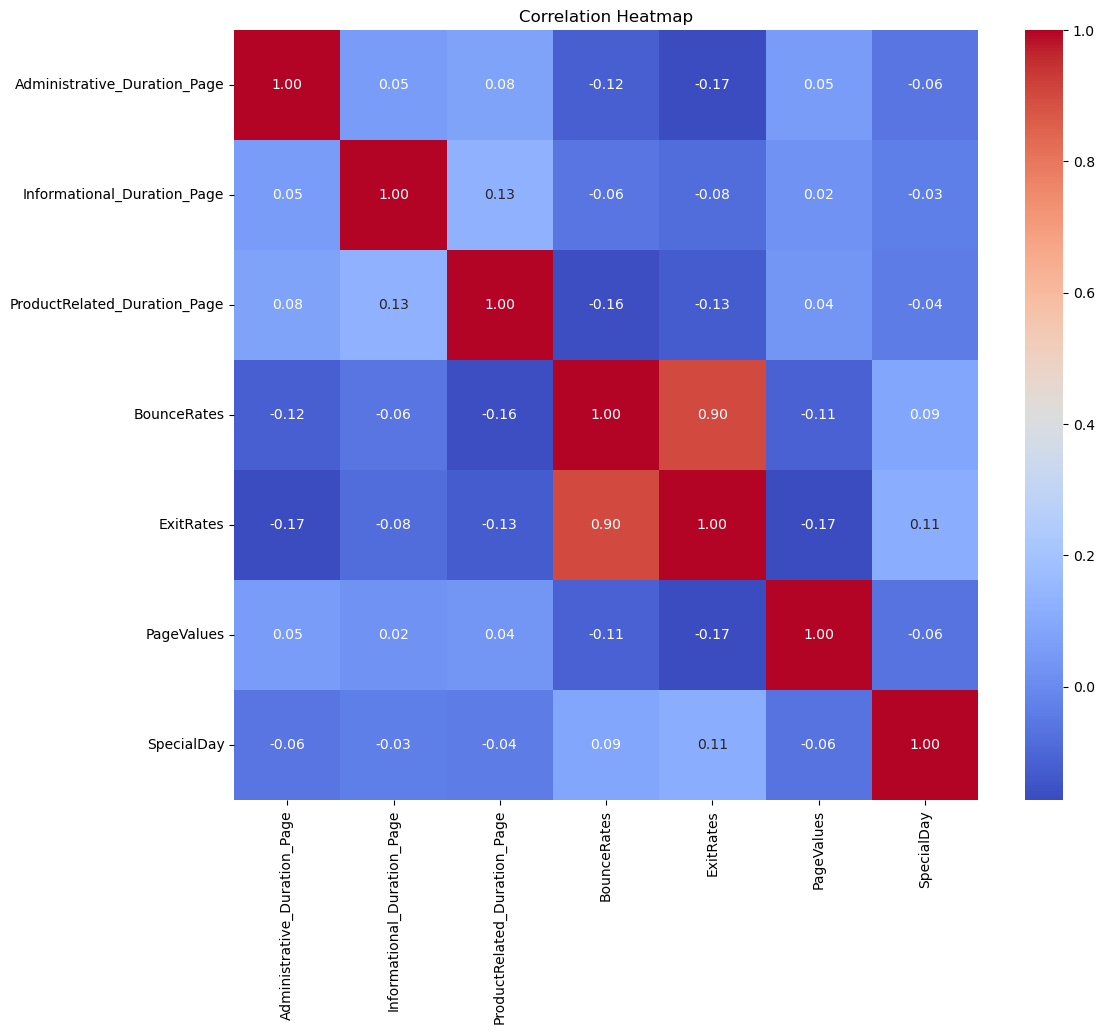

In [702]:
plt.figure(figsize=(12 , 10))
sns.heatmap(X_train[numerical_columns].corr(), cmap = 'coolwarm', annot = True, fmt = '.2f')
plt.title('Correlation Heatmap')

In [703]:
def ChiSquareContingency(data, y_train):
    p_value = chi2_contingency(pd.crosstab(data, y_train))[1]
    print(f'p-value: {p_value}')
    if p_value > 0.05:
        print(f'Accept H0, feature {data.name} is independent with Revenue')
    else:
        print(f'Reject H0, feature {data.name} is dependent with Revenue')

# Assuming you are iterating over categorical columns
for column in categorical_columns:
    ChiSquareContingency(X_train[column], y_train)
    print('')

p-value: 1.6351464585069558e-52
Reject H0, feature Month is dependent with Revenue

p-value: 1.0908594134349057e-08
Reject H0, feature OperatingSystems is dependent with Revenue

p-value: 0.007700184985415064
Reject H0, feature Browser is dependent with Revenue

p-value: 0.7276408547218776
Accept H0, feature Region is independent with Revenue

p-value: 1.7604246936686518e-42
Reject H0, feature TrafficType is dependent with Revenue

p-value: 2.3212741382161994e-21
Reject H0, feature VType_New_Visitor is dependent with Revenue

p-value: 0.9733241469555696
Accept H0, feature VType_Other is independent with Revenue

p-value: 8.81727274938809e-21
Reject H0, feature VType_Returning_Visitor is dependent with Revenue

p-value: 0.05252649771069415
Accept H0, feature Weekend is independent with Revenue



<Axes: ylabel='SpecialDay'>

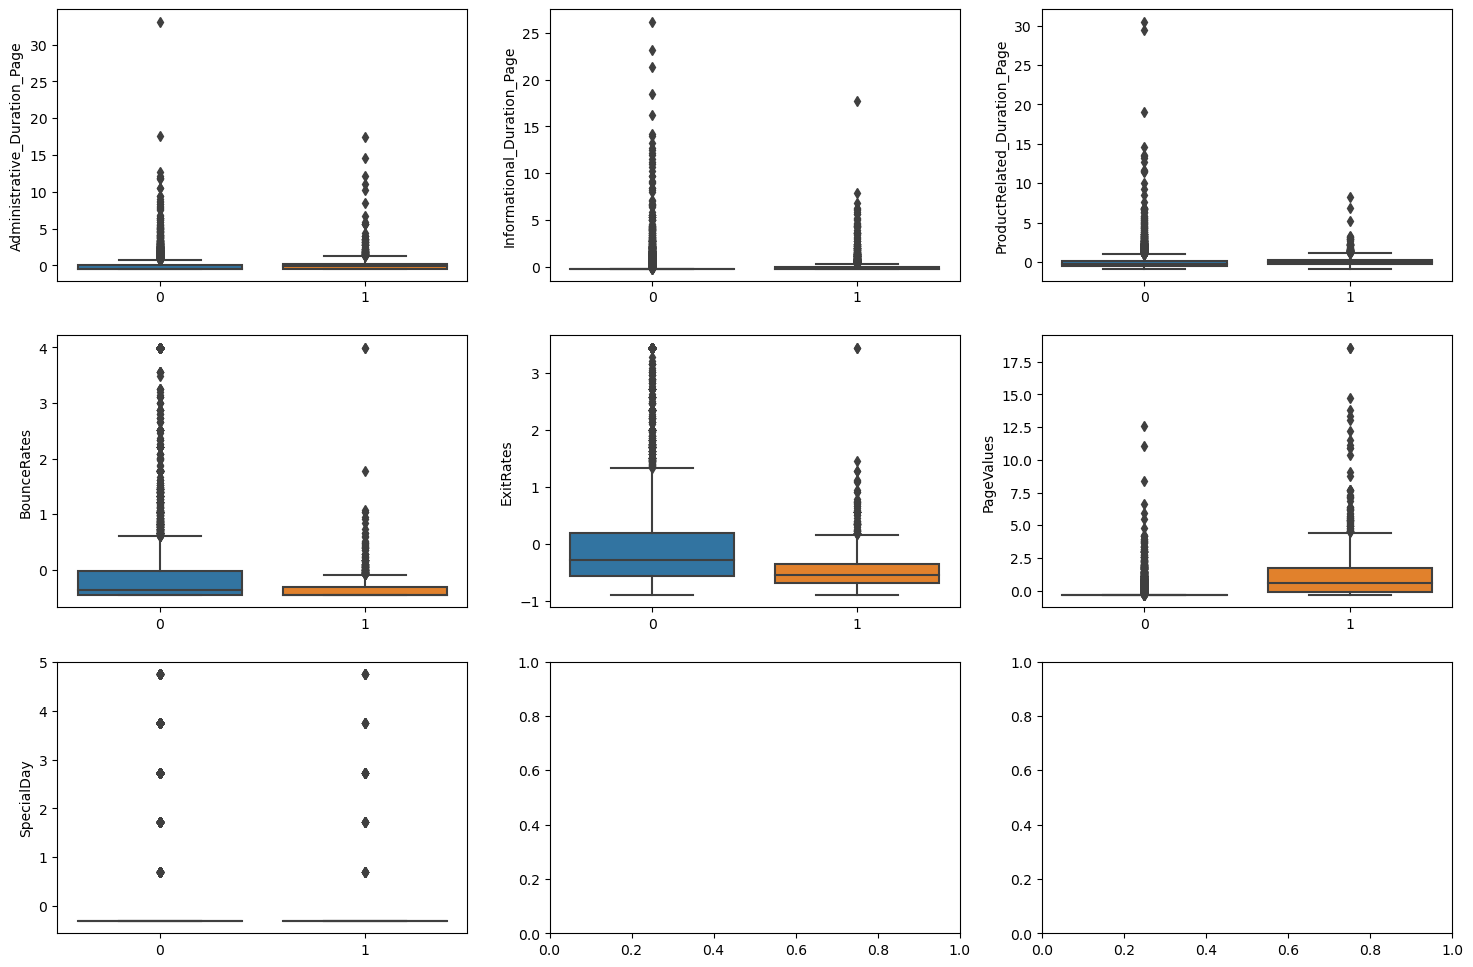

In [704]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


sns.boxplot(ax=axes[0, 0], x=y_train, y=X_train['Administrative_Duration_Page'])
sns.boxplot(ax=axes[0, 1], x=y_train, y=X_train['Informational_Duration_Page'])
sns.boxplot(ax=axes[0, 2], x=y_train, y=X_train['ProductRelated_Duration_Page'])
sns.boxplot(ax=axes[1, 0], x=y_train, y=X_train['BounceRates'])
sns.boxplot(ax=axes[1, 1], x=y_train, y=X_train['ExitRates'])
sns.boxplot(ax=axes[1, 2], x=y_train, y=X_train['PageValues'])
sns.boxplot(ax=axes[2, 0], x=y_train, y=X_train['SpecialDay'])



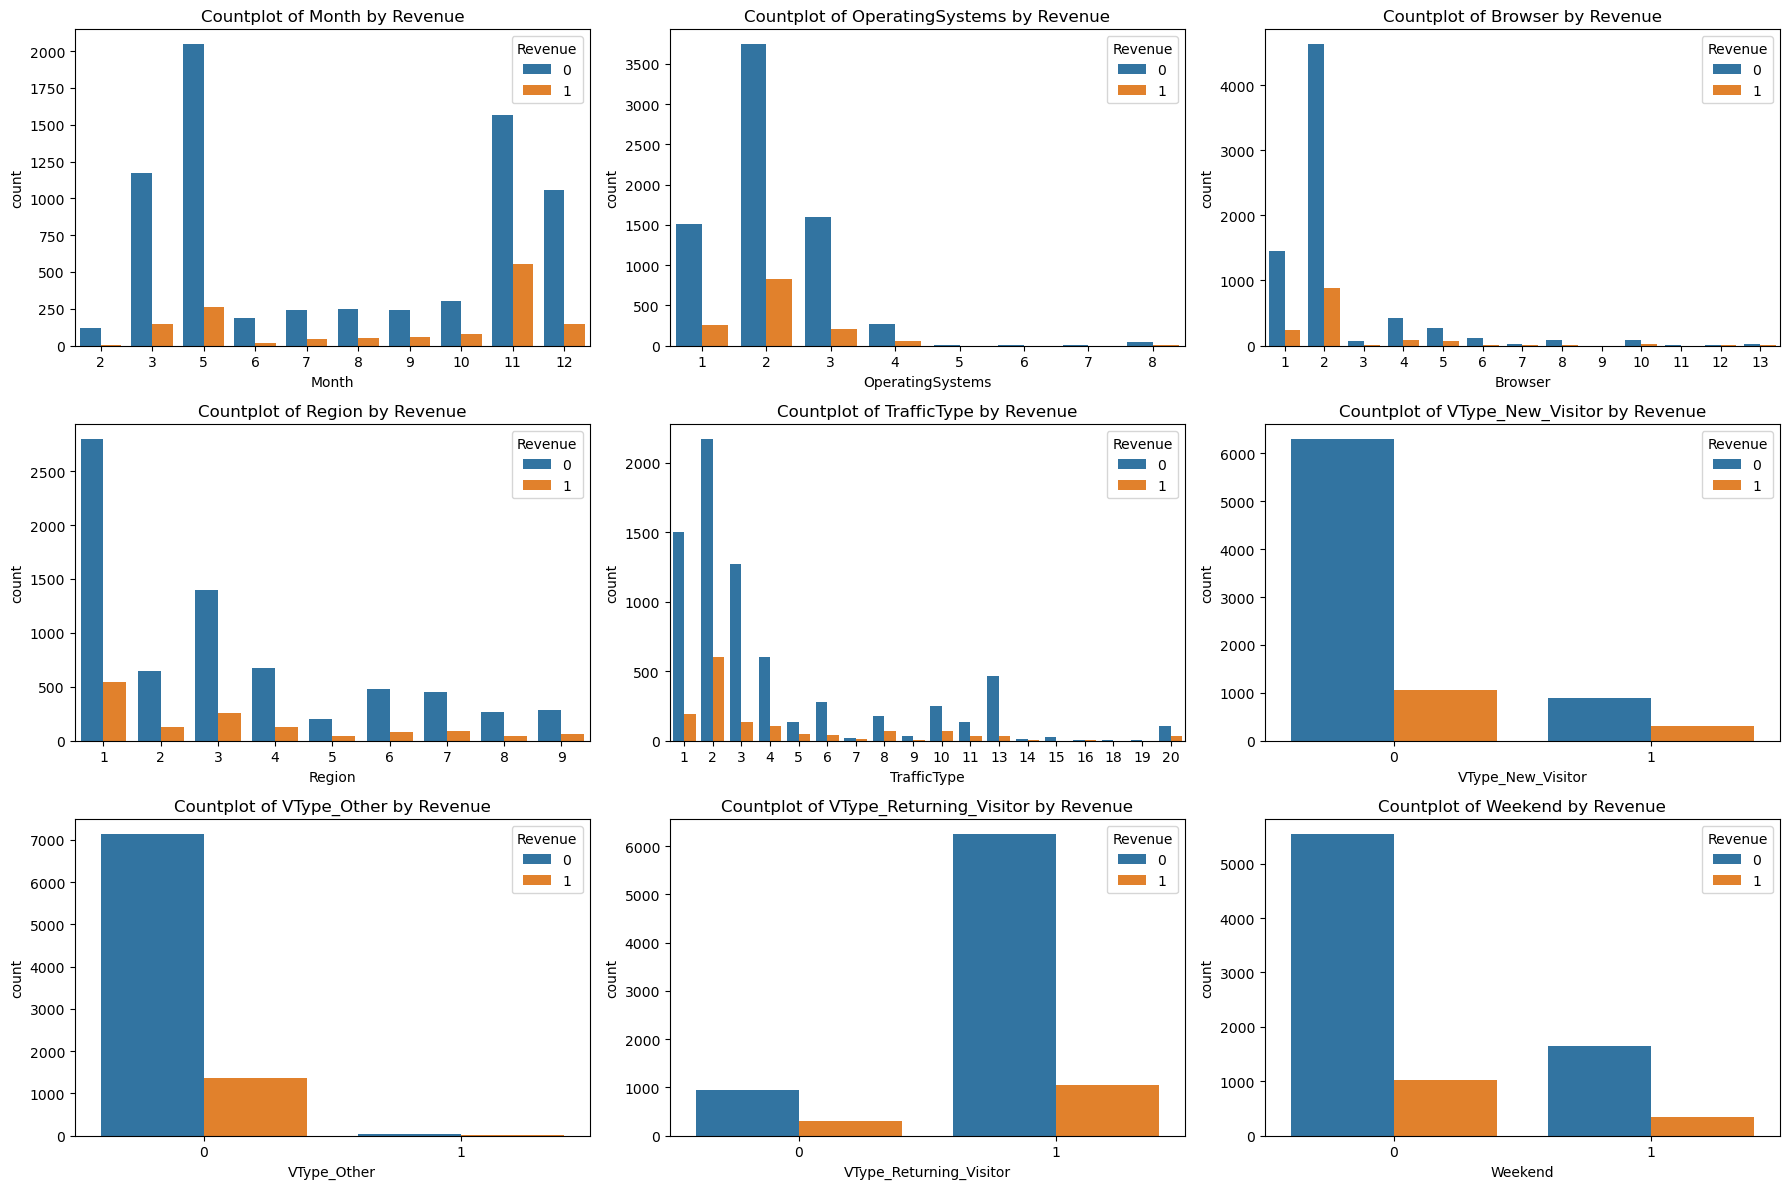

In [705]:
ig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Flatten the axes array to easily iterate over subplots
axes = axes.flatten()

# Loop through each categorical column and create a countplot in each subplot
for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, hue=y_train, data=X_train, ax=axes[i])
    axes[i].set_title(f'Countplot of {column} by Revenue')
    axes[i].legend(title='Revenue')
        

# Adjust layout to prevent overlap of subplots
plt.tight_layout()
plt.show()

# after SMOTE


Text(0.5, 1.0, 'Correlation Heatmap')

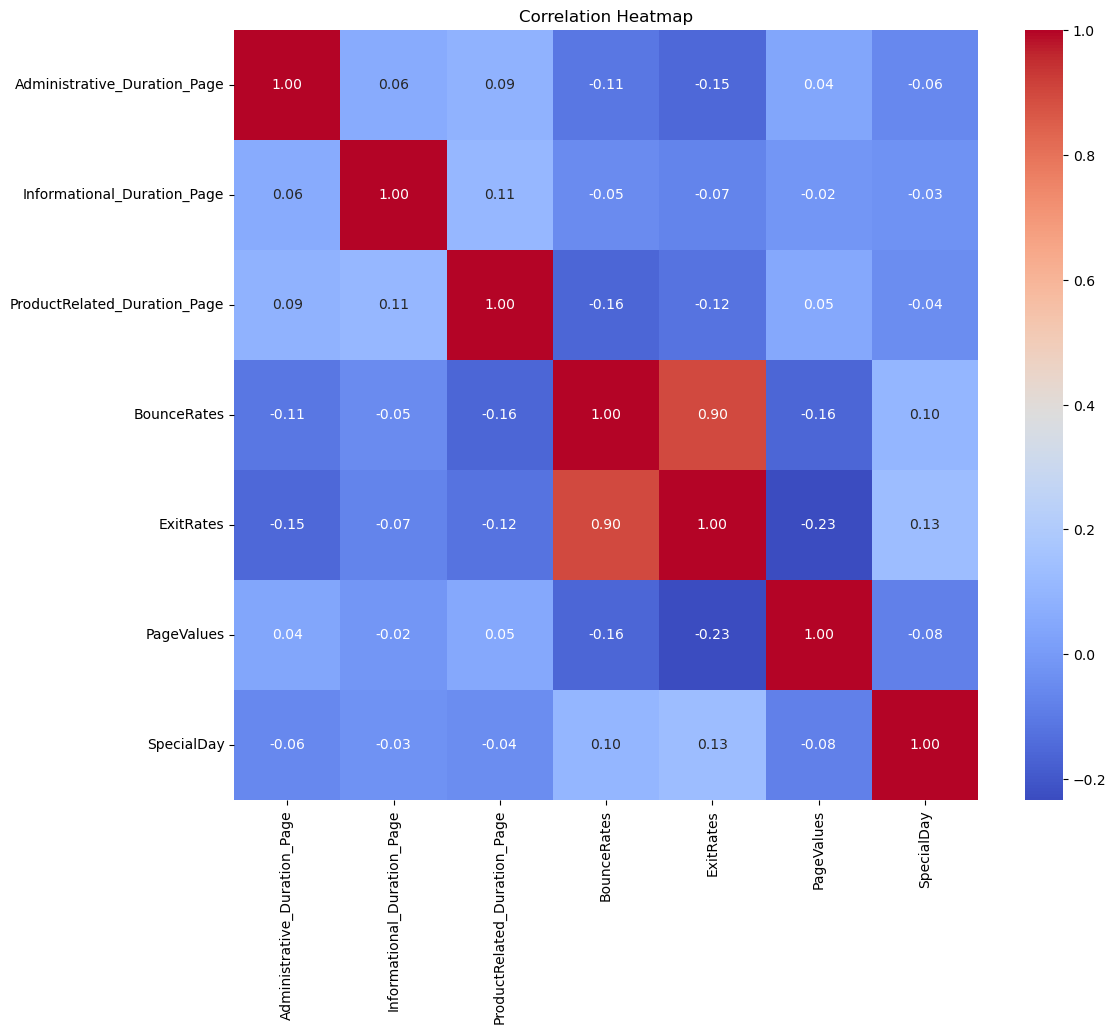

In [706]:
plt.figure(figsize=(12 , 10))
sns.heatmap(X_train_smote[numerical_columns].corr(), cmap = 'coolwarm', annot = True, fmt = '.2f')
plt.title('Correlation Heatmap')

In [707]:
def ChiSquareContingency(data, y_train):
    p_value = chi2_contingency(pd.crosstab(data, y_train))[1]
    print(f'p-value: {p_value}')
    if p_value > 0.05:
        print(f'Accept H0, feature {data.name} is independent with Revenue')
    else:
        print(f'Reject H0, feature {data.name} is dependent with Revenue')

# Assuming you are iterating over categorical columns
for column in categorical_columns:
    ChiSquareContingency(X_train_smote[column], y_train_smote)
    print('')

p-value: 5.290032645933025e-257
Reject H0, feature Month is dependent with Revenue

p-value: 9.068400960636884e-103
Reject H0, feature OperatingSystems is dependent with Revenue

p-value: 2.0925268150326875e-10
Reject H0, feature Browser is dependent with Revenue

p-value: 1.237610312539146e-10
Reject H0, feature Region is dependent with Revenue

p-value: 1.412337199881038e-189
Reject H0, feature TrafficType is dependent with Revenue

p-value: 9.769875868556175e-08
Reject H0, feature VType_New_Visitor is dependent with Revenue

p-value: 0.39497043866938597
Accept H0, feature VType_Other is independent with Revenue

p-value: 1.2613367546892577e-102
Reject H0, feature VType_Returning_Visitor is dependent with Revenue

p-value: 3.305964077442918e-44
Reject H0, feature Weekend is dependent with Revenue



<Axes: ylabel='SpecialDay'>

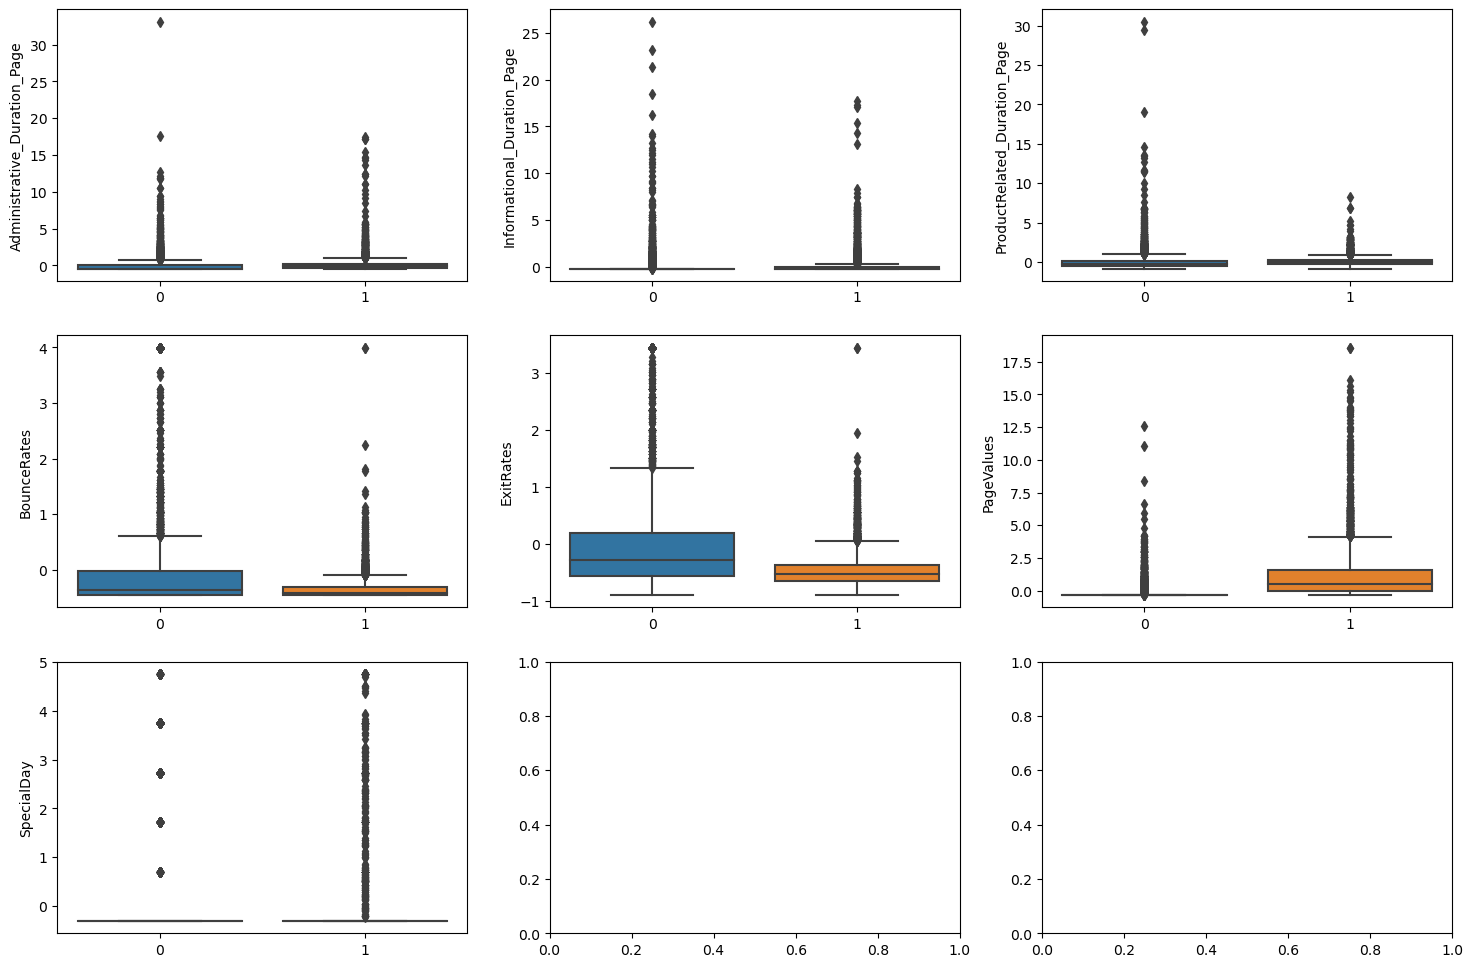

In [708]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


sns.boxplot(ax=axes[0, 0], x=y_train_smote, y=X_train_smote['Administrative_Duration_Page'])
sns.boxplot(ax=axes[0, 1], x=y_train_smote, y=X_train_smote['Informational_Duration_Page'])
sns.boxplot(ax=axes[0, 2], x=y_train_smote, y=X_train_smote['ProductRelated_Duration_Page'])
sns.boxplot(ax=axes[1, 0], x=y_train_smote, y=X_train_smote['BounceRates'])
sns.boxplot(ax=axes[1, 1], x=y_train_smote, y=X_train_smote['ExitRates'])
sns.boxplot(ax=axes[1, 2], x=y_train_smote, y=X_train_smote['PageValues'])
sns.boxplot(ax=axes[2, 0], x=y_train_smote, y=X_train_smote['SpecialDay'])



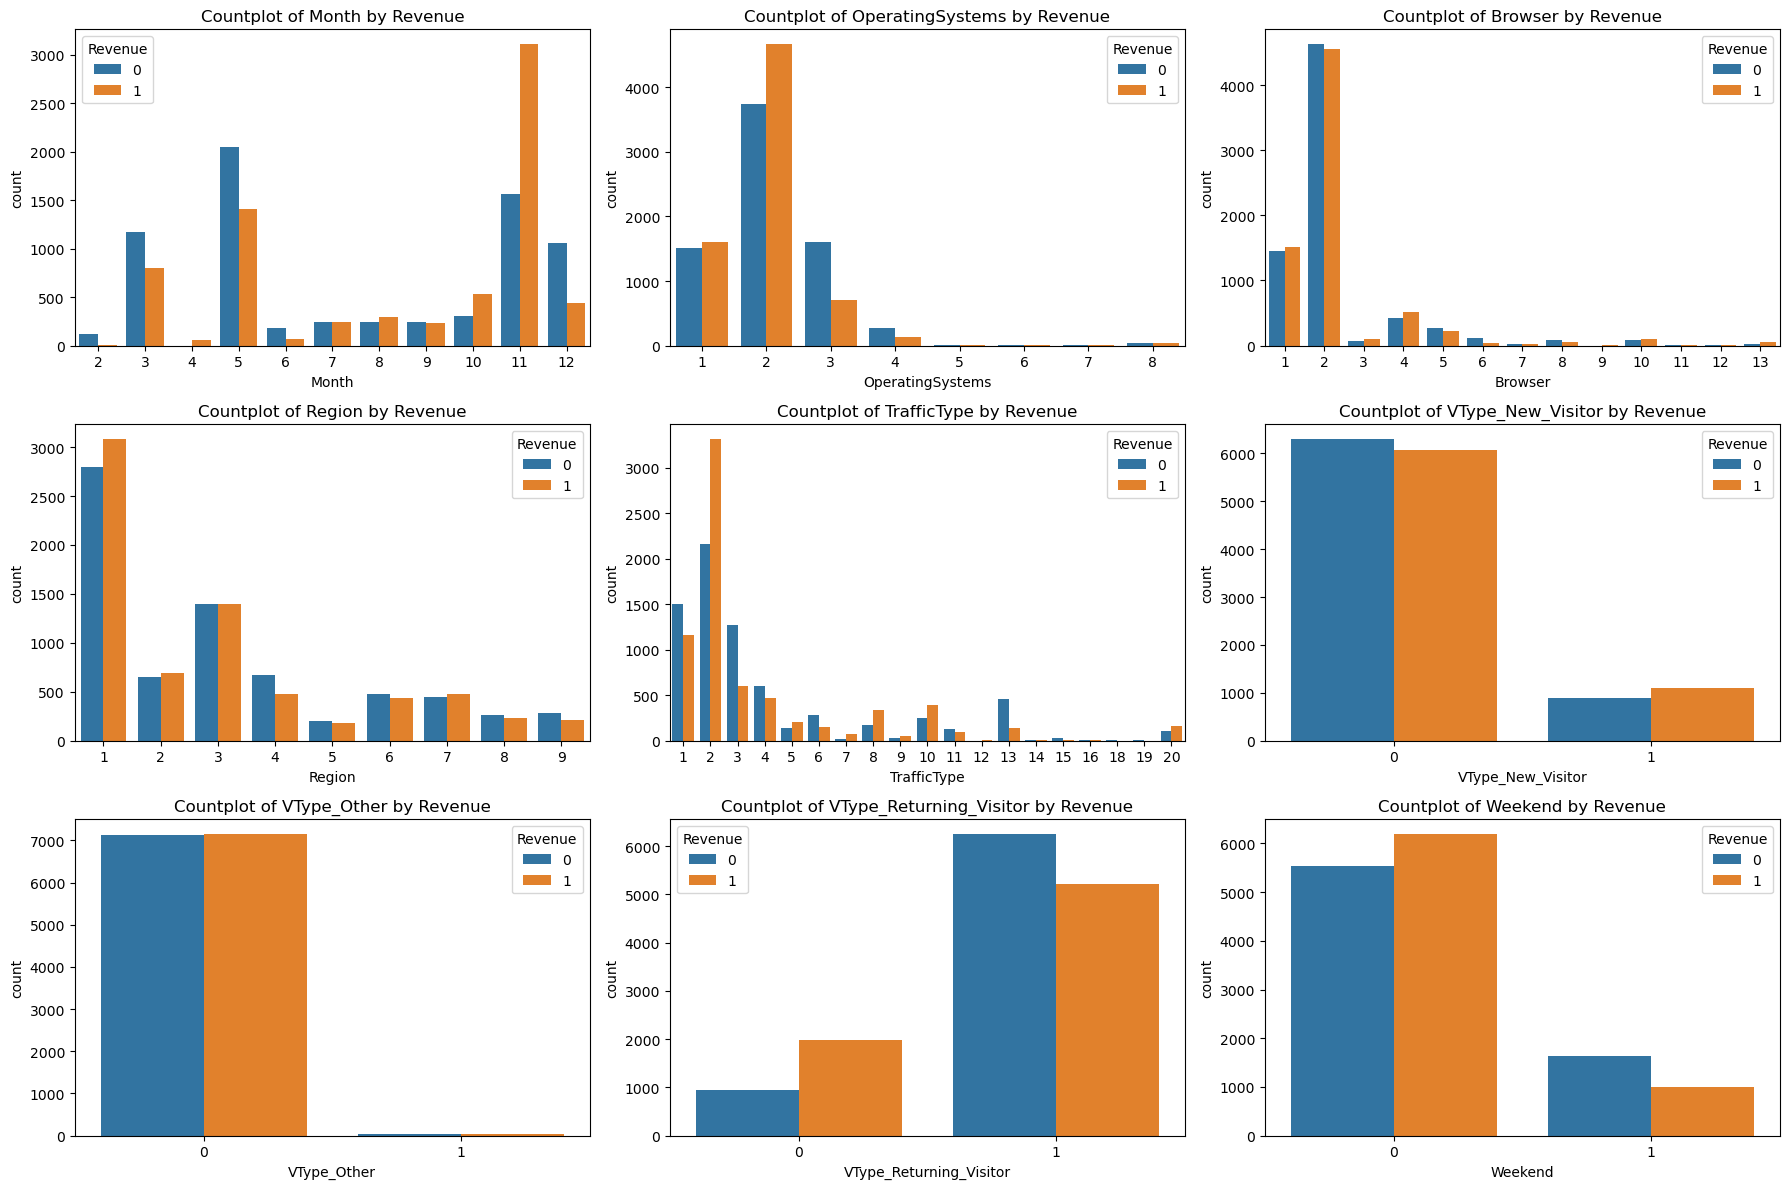

In [709]:
ig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Flatten the axes array to easily iterate over subplots
axes = axes.flatten()

# Loop through each categorical column and create a countplot in each subplot
for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, hue=y_train_smote, data=X_train_smote, ax=axes[i])
    axes[i].set_title(f'Countplot of {column} by Revenue')
    axes[i].legend(title='Revenue')
    
    

# Adjust layout to prevent overlap of subplots
plt.tight_layout()
plt.show()

# clustering


In [710]:
# from sklearn.cluster import KMeans
# cs = []
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
#     kmeans.fit(X_train)
#     labels=kmeans.labels_
#     cs.append(kmeans.inertia_)
# plt.plot(range(1, 11), cs)
# plt.grid()
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('CS')
# plt.show()

In [711]:
# km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
# y_means = km.fit_predict(X_train)
# y_means